/tmp/ipykernel_319291/620002061.py:181: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


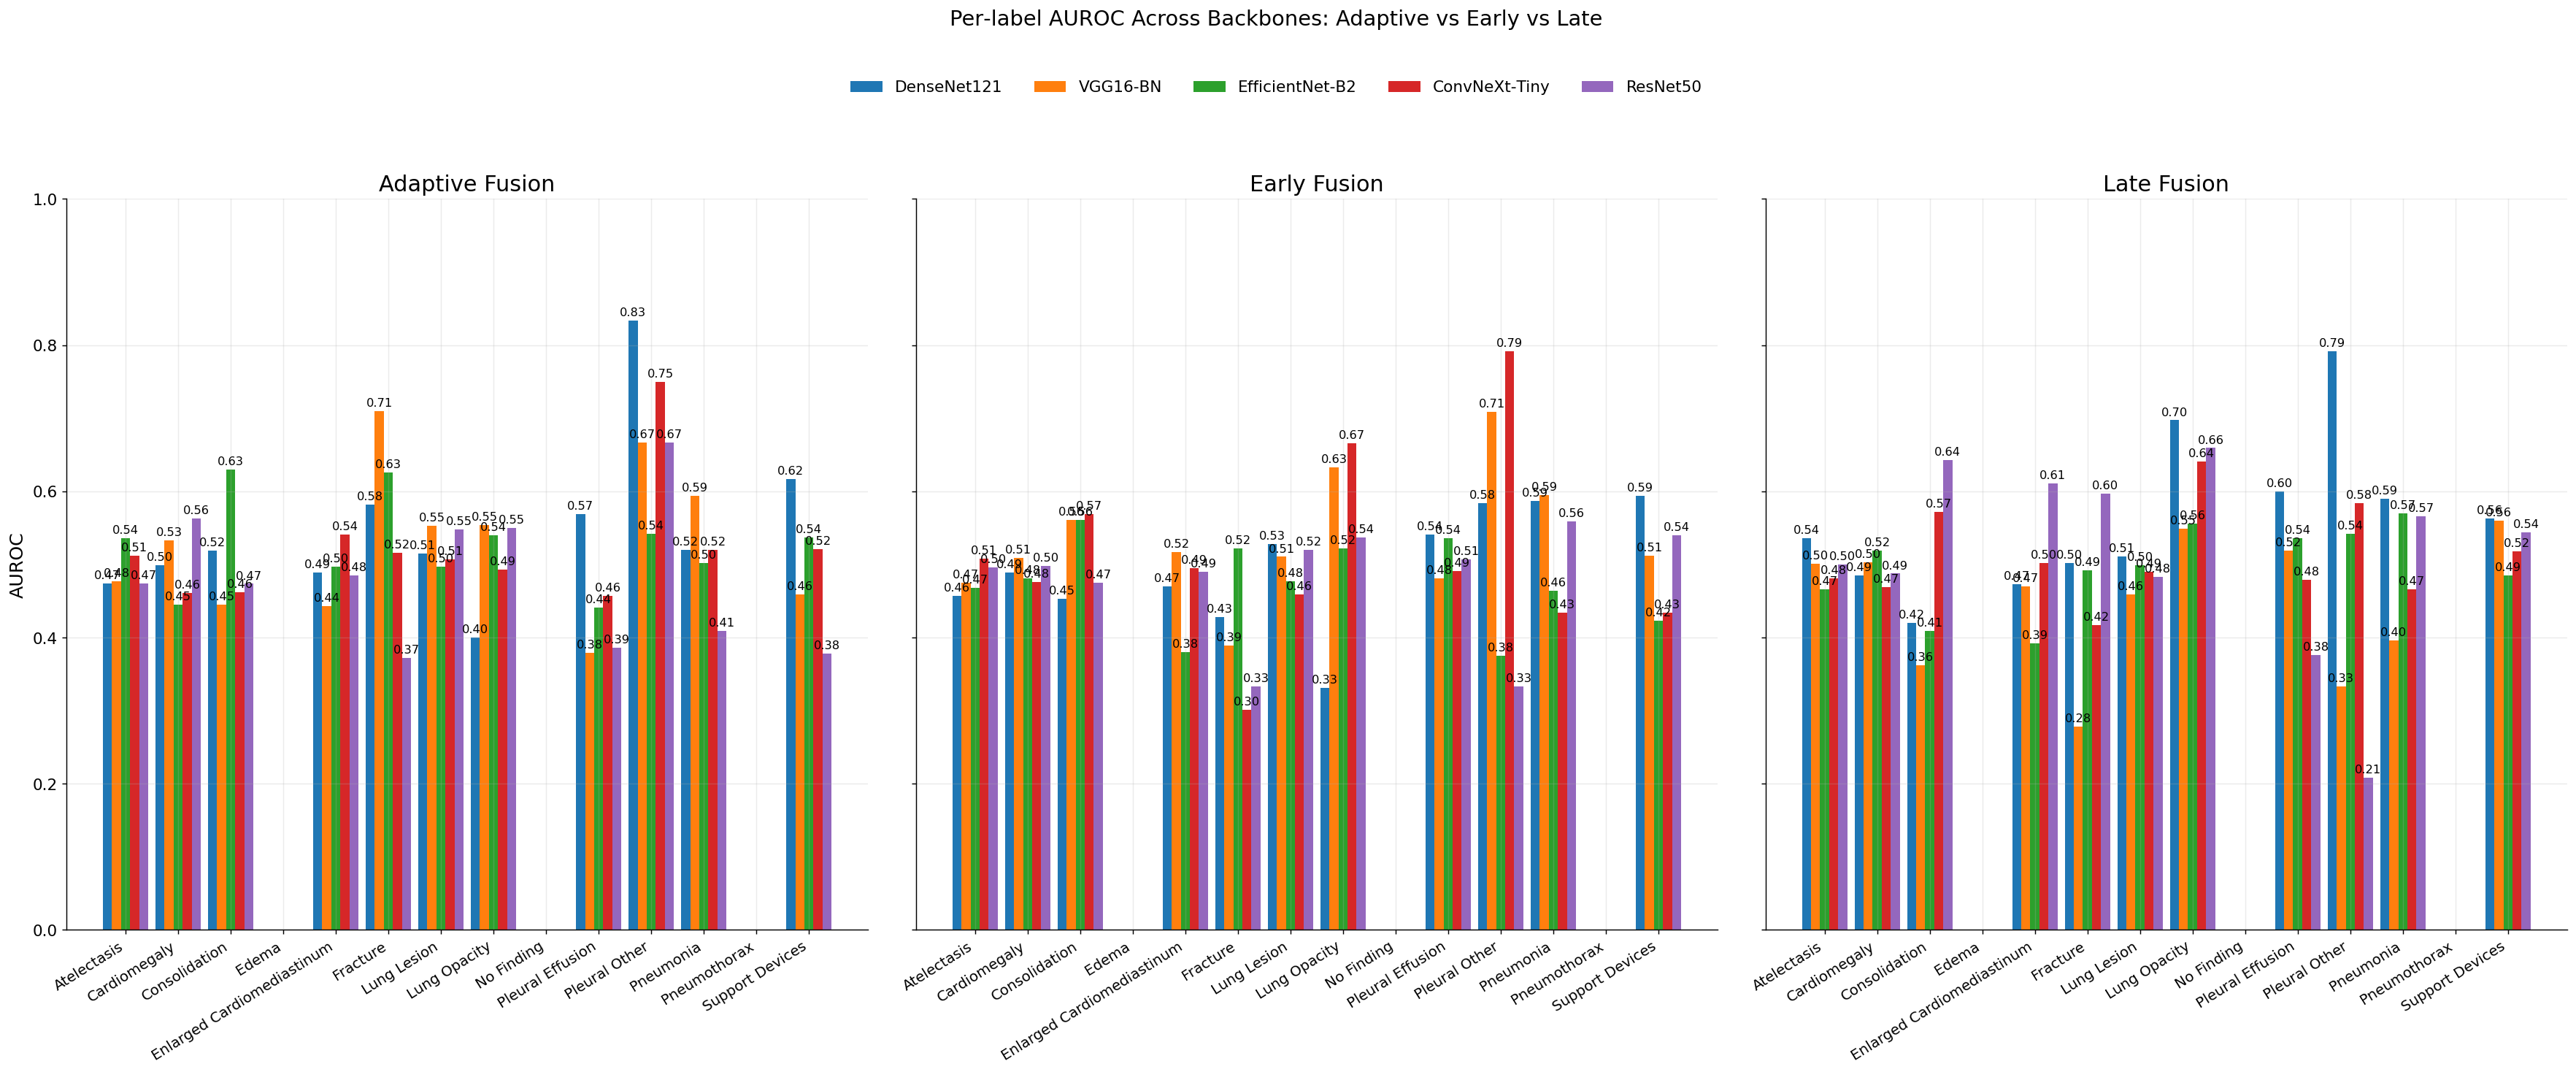

Saved → checkpoints/eval_compare/per_label_auroc_tripanel_adaptive_early_late.png


In [ ]:
# === tri_panel_per_label_auroc.py ===
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 1) Config: where to read results
# -----------------------------
# Adaptive
ADAPTIVE_CSVS = {
    "densenet121": "/data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/training/CXR_ECG_LABS_AdaptiveFusion/checkpoints/eval_densenet121/densenet121_per_label_metrics.csv",
    "vgg16_bn": "/data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/training/CXR_ECG_LABS_AdaptiveFusion/checkpoints/eval_vgg16_bn/vgg16_bn_per_label_metrics.csv",
    "efficientnet_b2": "/data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/training/CXR_ECG_LABS_AdaptiveFusion/checkpoints/eval_efficientnet_b2/efficientnet_b2_per_label_metrics.csv",
    "convnext_tiny": "/data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/training/CXR_ECG_LABS_AdaptiveFusion/checkpoints/eval_convnext_tiny/convnext_tiny_per_label_metrics.csv",
    "resnet50": "/data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/training/CXR_ECG_LABS_AdaptiveFusion/checkpoints/eval_resnet50/resnet50_per_label_metrics.csv",
}

# Early & Late dirs 
EARLY_DIR = Path("/data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/training/CXR_ECG_LABS_EarlyFusion/checkpoints/eval_early")
LATE_DIR  = Path("/data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/training/CXR_ECG_LABS_Late_Fusionimproving/checkpoints/eval_late")

BACKBONES = ["densenet121","vgg16_bn","efficientnet_b2","convnext_tiny","resnet50"]

PRETTY = {
    "resnet50": "ResNet50",
    "densenet121": "DenseNet121",
    "efficientnet_b2": "EfficientNet‑B2",
    "convnext_tiny": "ConvNeXt‑Tiny",
    "vgg16_bn": "VGG16‑BN",
}

OUT_DIR = Path("./checkpoints/eval_compare")
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_PNG = OUT_DIR / "per_label_auroc_tripanel_adaptive_early_late.png"

# -----------------------------
# 2) Small IO helpers (robust to case)
# -----------------------------
def read_per_label_csv(csv_path):
    df = pd.read_csv(csv_path)
    # normalize column names
    cols = {c.lower(): c for c in df.columns}
    # trying common spellings
    label_col = cols.get("label") or cols.get("labels")
    auroc_col = (
        cols.get("auroc")
        or cols.get("roc_auc")
        or cols.get("auc")
    )
    if label_col is None or auroc_col is None:
        raise ValueError(f"CSV {csv_path} must contain label + auroc columns; got {df.columns.tolist()}")
    out = df[[label_col, auroc_col]].copy()
    out.columns = ["label", "auroc"]
    return out

def load_strategy_per_label(strategy_name, sources):
    """
    strategy_name: 'Adaptive' | 'Early' | 'Late'
    sources:
      - dict backbone->csv (Adaptive), or
      - Path to directory with per_label_{backbone}.csv (Early/Late)
    returns dict: backbone -> DataFrame(label, auroc)
    """
    results = {}
    if isinstance(sources, dict):
        for b, p in sources.items():
            results[b] = read_per_label_csv(p)
    else:
        base = Path(sources)
        for b in BACKBONES:
            p = base / f"per_label_{b}.csv"
            if not p.exists():
                # sometimes Late CSV used lowercase 'auroc', still read_per_label_csv handles it
                # just ensure the filename pattern is correct
                pass
            results[b] = read_per_label_csv(p)
    return results

# -----------------------------
# 3) Load all three strategies
# -----------------------------
adaptive = load_strategy_per_label("Adaptive", ADAPTIVE_CSVS)
early    = load_strategy_per_label("Early", EARLY_DIR)
late     = load_strategy_per_label("Late",  LATE_DIR)

# Establish a consistent label order (take intersection across all that exist)
labels_sets = []
for coll in (adaptive, early, late):
    for b in BACKBONES:
        if b in coll:
            labels_sets.append(set(coll[b]["label"].tolist()))
common_labels = sorted(list(set.intersection(*labels_sets))) if labels_sets else []
if not common_labels:
    # fallback to first available set
    for coll in (adaptive, early, late):
        if coll:
            any_df = next(iter(coll.values()))
            common_labels = any_df["label"].tolist()
            break

# -----------------------------
# 4) Build matrices per strategy (rows=labels, cols=backbones)
# -----------------------------
def build_matrix(per_label_dict, labels, backbones):
    mat = np.full((len(labels), len(backbones)), np.nan, dtype=float)
    for j, b in enumerate(backbones):
        if b not in per_label_dict:
            continue
        s = per_label_dict[b].set_index("label")["auroc"]
        for i, lab in enumerate(labels):
            if lab in s:
                mat[i, j] = s[lab]
    return mat

M_adapt = build_matrix(adaptive, common_labels, BACKBONES)
M_early = build_matrix(early,    common_labels, BACKBONES)
M_late  = build_matrix(late,     common_labels, BACKBONES)

# -----------------------------
# 5) Plot: three aligned subplots with annotations
# -----------------------------
plt.rcParams.update({
    "figure.dpi": 130,
    "font.size": 14,
    "xtick.labelsize": 11,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "axes.grid": True, "grid.alpha": 0.25,
    "axes.spines.top": False, "axes.spines.right": False,
})

fig, axes = plt.subplots(
    1, 3, figsize=(34, 10), sharey=True,
    gridspec_kw={"wspace": 0.06}
)
titles = ["Adaptive Fusion", "Early Fusion", "Late Fusion"]
mats   = [M_adapt, M_early, M_late]

n_labels = len(common_labels)
n_bb     = len(BACKBONES)
x        = np.arange(n_labels)
group_w  = 0.86
bar_w    = group_w / n_bb
offsets  = (np.arange(n_bb) - (n_bb-1)/2) * bar_w

def annotate_barcontainer(ax, bc, fmt="{:.2f}"):
    for rect in bc:
        h = rect.get_height()
        if np.isnan(h) or h <= 0:
            continue
        ax.annotate(fmt.format(h),
                    xy=(rect.get_x() + rect.get_width()/2, h),
                    xytext=(0, 2), textcoords="offset points",
                    ha="center", va="bottom", fontsize=9)

# draw each panel
handles_for_legend = None
for ax, title, M in zip(axes, titles, mats):
    bars = []
    for j, b in enumerate(BACKBONES):
        vals = np.nan_to_num(M[:, j], nan=0.0)
        bc = ax.bar(x + offsets[j], vals, width=bar_w, label=PRETTY.get(b, b))
        bars.append(bc)
        annotate_barcontainer(ax, bc)

    ax.set_ylim(0.0, 1.0)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(common_labels, rotation=32, ha="right")
    ax.set_ylabel("AUROC" if ax is axes[0] else "")
    if handles_for_legend is None:
        handles_for_legend = [bc[0] for bc in bars]  # one handle per backbone

# Shared legend above
fig.legend(handles_for_legend, [PRETTY[b] for b in BACKBONES],
           ncols=min(5, n_bb), loc="upper center", bbox_to_anchor=(0.5, 1.02), frameon=False)

fig.suptitle("Per‑label AUROC Across Backbones: Adaptive vs Early vs Late", y=1.08, fontsize=16)
fig.tight_layout()
fig.savefig(OUT_PNG, dpi=240, bbox_inches="tight")
plt.show()
print(f"Saved → {OUT_PNG}")


/tmp/ipykernel_319291/2515965273.py:76: RuntimeWarning: Mean of empty slice
  mean_scores = np.nanmean(np.stack([M_adapt, M_early, M_late], axis=0), axis=(0,2))


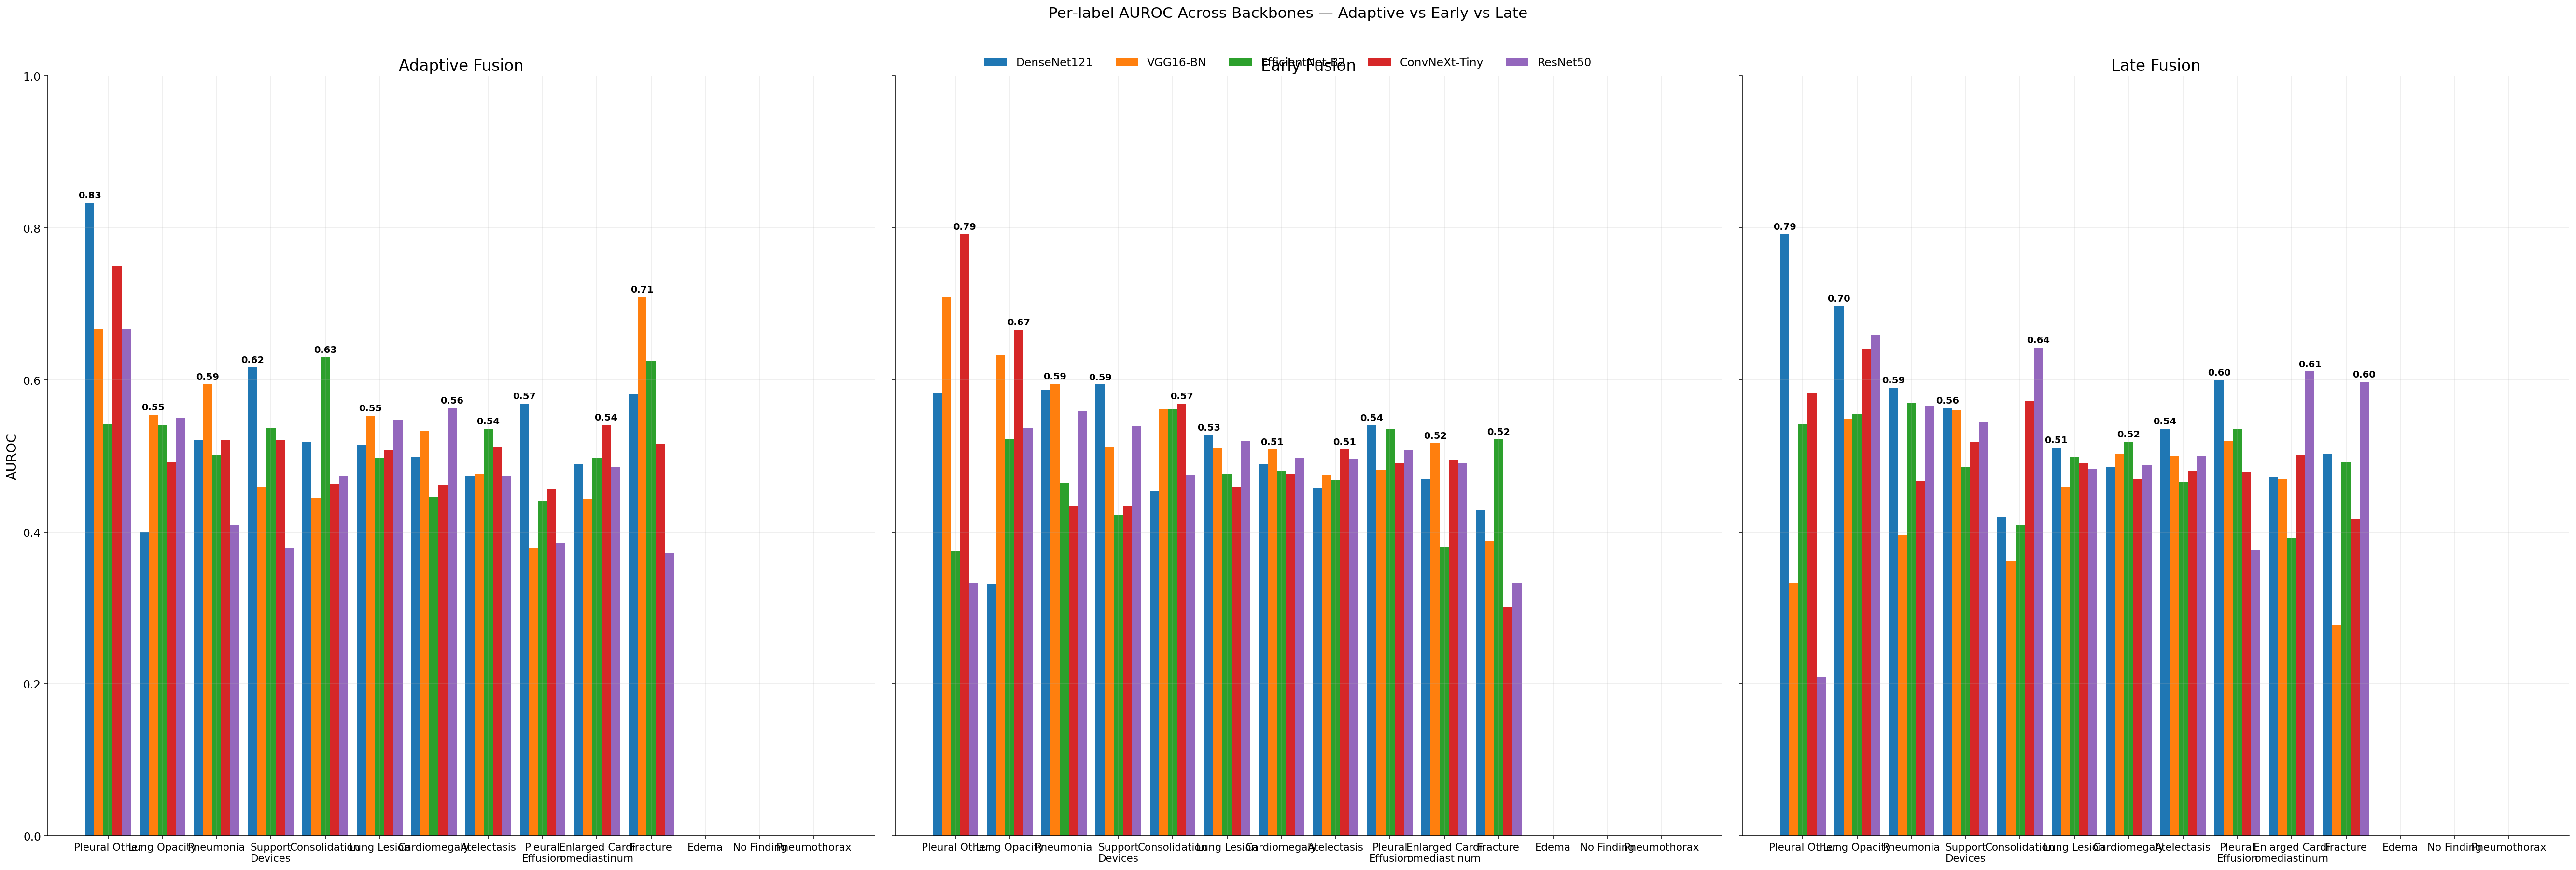

Saved → checkpoints/eval_compare/per_label_auroc_tripanel_clean.png


In [ ]:
# === tri_panel_per_label_auroc_clean.py ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import textwrap

# ----- inputs ----
ADAPTIVE_CSVS = {
    "densenet121": "/data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/training/CXR_ECG_LABS_AdaptiveFusion/checkpoints/eval_densenet121/densenet121_per_label_metrics.csv",
    "vgg16_bn": "/data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/training/CXR_ECG_LABS_AdaptiveFusion/checkpoints/eval_vgg16_bn/vgg16_bn_per_label_metrics.csv",
    "efficientnet_b2": "/data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/training/CXR_ECG_LABS_AdaptiveFusion/checkpoints/eval_efficientnet_b2/efficientnet_b2_per_label_metrics.csv",
    "convnext_tiny": "/data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/training/CXR_ECG_LABS_AdaptiveFusion/checkpoints/eval_convnext_tiny/convnext_tiny_per_label_metrics.csv",
    "resnet50": "/data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/training/CXR_ECG_LABS_AdaptiveFusion/checkpoints/eval_resnet50/resnet50_per_label_metrics.csv",
}
# Early & Late dirs
EARLY_DIR = Path("/data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/training/CXR_ECG_LABS_EarlyFusion/checkpoints/eval_early")
LATE_DIR  = Path("/data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/training/CXR_ECG_LABS_Late_Fusionimproving/checkpoints/eval_late")

BACKBONES = ["densenet121","vgg16_bn","efficientnet_b2","convnext_tiny","resnet50"]
PRETTY = {
    "resnet50":"ResNet50","densenet121":"DenseNet121",
    "efficientnet_b2":"EfficientNet‑B2","convnext_tiny":"ConvNeXt‑Tiny","vgg16_bn":"VGG16‑BN",
}
OUT_PNG = Path("./checkpoints/eval_compare/per_label_auroc_tripanel_clean.png")

# ----- knobs -----
ANNOTATE_BEST_ONLY = True    # annotate just the best bar per label (per panel)
DECIMALS = 2
SORT_LABELS = True           # sort labels by mean AUROC across all panels (reduces zig-zag)
WRAP_WIDTH = 14              # wrap x‑tick labels into two lines if long

def read_per_label_csv(csv_path):
    df = pd.read_csv(csv_path)
    cols = {c.lower(): c for c in df.columns}
    label_col = cols.get("label") or cols.get("labels")
    auroc_col = cols.get("auroc") or cols.get("roc_auc") or cols.get("auc")
    if label_col is None or auroc_col is None:
        raise ValueError(f"{csv_path} must contain label + auroc")
    out = df[[label_col, auroc_col]].copy()
    out.columns = ["label", "auroc"]
    return out

def load_dir(base, backbones):
    out = {}
    for b in backbones:
        out[b] = read_per_label_csv(base / f"per_label_{b}.csv")
    return out

def build_matrix(per_label_dict, labels, backbones):
    M = np.full((len(labels), len(backbones)), np.nan, float)
    for j, b in enumerate(backbones):
        s = per_label_dict[b].set_index("label")["auroc"]
        for i, lab in enumerate(labels):
            if lab in s:
                M[i, j] = s[lab]
    return M

# --- load all three strategies ---
adaptive = {b: read_per_label_csv(p) for b, p in ADAPTIVE_CSVS.items()}
early    = load_dir(EARLY_DIR, BACKBONES)
late     = load_dir(LATE_DIR,  BACKBONES)

# common label order
labels_sets = [set(df["label"]) for df in adaptive.values()] \
            + [set(df["label"]) for df in early.values()] \
            + [set(df["label"]) for df in late.values()]
labels = sorted(list(set.intersection(*labels_sets)))

M_adapt = build_matrix(adaptive, labels, BACKBONES)
M_early = build_matrix(early,    labels, BACKBONES)
M_late  = build_matrix(late,     labels, BACKBONES)

# optional: sort labels by mean AUROC (across all panels/backbones)
if SORT_LABELS:
    mean_scores = np.nanmean(np.stack([M_adapt, M_early, M_late], axis=0), axis=(0,2))
    order = np.argsort(-mean_scores)   # descending
    labels = [labels[i] for i in order]
    M_adapt = M_adapt[order]
    M_early = M_early[order]
    M_late  = M_late[order]

def wrap_labels(names, width=14):
    return ["\n".join(textwrap.wrap(n, width=width)) for n in names]

# ---- plotting (use constrained_layout to avoid the warning) ----
plt.rcParams.update({
    "figure.dpi": 140,
    "font.size": 14,
    "xtick.labelsize": 11,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "axes.grid": True, "grid.alpha": 0.25,
    "axes.spines.top": False, "axes.spines.right": False,
})

fig, axes = plt.subplots(
    1, 3, figsize=(38, 12), sharey=True, constrained_layout=True
)
titles = ["Adaptive Fusion", "Early Fusion", "Late Fusion"]
mats   = [M_adapt, M_early, M_late]

n_labels = len(labels)
n_bb = len(BACKBONES)
x = np.arange(n_labels)
group_w = 0.84
bar_w   = group_w / n_bb
offsets = (np.arange(n_bb) - (n_bb-1)/2) * bar_w

legend_handles = None

for ax, title, M in zip(axes, titles, mats):
    bars_for_legend = []
    # draw bars
    for j, b in enumerate(BACKBONES):
        vals = np.nan_to_num(M[:, j], nan=0.0)
        bc = ax.bar(x + offsets[j], vals, width=bar_w, label=PRETTY.get(b, b))
        bars_for_legend.append(bc)
    # annotate
    
    if ANNOTATE_BEST_ONLY:
        # Annotate only the best bar per label, but skip all-NaN rows
        for i in range(n_labels):
            row = M[i, :]
            if np.all(np.isnan(row)):
                continue  # nothing to annotate for this label in this panel
            j = int(np.nanargmax(row))
            v = row[j]
            xpos = x[i] + offsets[j]
            ax.annotate(f"{v:.{DECIMALS}f}",
                        xy=(xpos, v), xytext=(0, 3),
                        textcoords="offset points", ha="center", va="bottom",
                        fontsize=10, fontweight="bold")
    else:
        # Annotate every bar, but skip NaNs
        for j in range(n_bb):
            for i, rect in enumerate(bars_for_legend[j]):
                v = M[i, j]
                if np.isnan(v) or v <= 0:
                    continue
                ax.annotate(f"{v:.{DECIMALS}f}",
                            xy=(rect.get_x() + rect.get_width()/2, v),
                            xytext=(0, 2), textcoords="offset points",
                            ha="center", va="bottom", fontsize=8)


    ax.set_title(title)
    ax.set_ylim(0.0, 1.0)
    ax.set_xticks(x)
    ax.set_xticklabels(wrap_labels(labels, WRAP_WIDTH), rotation=0)
    ax.set_ylabel("AUROC" if ax is axes[0] else "")

    if legend_handles is None:
        legend_handles = [bc[0] for bc in bars_for_legend]

# shared legend at top
fig.legend(legend_handles, [PRETTY[b] for b in BACKBONES],
           ncols=min(5, n_bb), loc="upper center", bbox_to_anchor=(0.5, 1.01), frameon=False)

fig.suptitle("Per‑label AUROC Across Backbones — Adaptive vs Early vs Late", y=1.06, fontsize=16)
fig.savefig(OUT_PNG, dpi=300)
plt.show()
print(f"Saved → {OUT_PNG}")


In [4]:
import pandas as pd

# Load the 3 training summaries
df_adapt = pd.read_csv("/data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/training/CXR_ECG_LABS_AdaptiveFusion/checkpoints/backbone_sweep_summary.csv")
df_adapt["fusion_type"] = "Adaptive"

df_early = pd.read_csv("/data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/training/CXR_ECG_LABS_EarlyFusion/checkpoints/early_backbone_sweep_summary.csv")
df_early["fusion_type"] = "Early"

df_late = pd.read_csv("/data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/training/CXR_ECG_LABS_Late_Fusionimproving/checkpoints/late_backbone_sweep_summary.csv")
df_late["fusion_type"] = "Late"

# Merge
df_all_train = pd.concat([df_adapt, df_early, df_late], ignore_index=True)

# Keep only relevant training columns
cols_train = [
    "fusion_type","backbone",
    "best_val_macro_auc","test_macro_auc","test_flat_auc",
    "train_total_sec","train_avg_epoch_sec","train_peak_gpu_GB"
]
df_all_train = df_all_train[cols_train]

print(df_all_train)
df_all_train.to_csv("checkpoints/all_fusion_training_summary.csv", index=False)
print("Saved combined training summary → checkpoints/all_fusion_training_summary.csv")


   fusion_type         backbone  best_val_macro_auc  test_macro_auc  \
0     Adaptive         resnet50            0.548720        0.482071   
1     Adaptive      densenet121            0.571548        0.546893   
2     Adaptive  efficientnet_b2            0.525921        0.526565   
3     Adaptive    convnext_tiny            0.562373        0.521833   
4     Adaptive         vgg16_bn            0.596892        0.528475   
5        Early         resnet50            0.565907        0.480782   
6        Early      densenet121            0.578697        0.496488   
7        Early  efficientnet_b2            0.595899        0.473336   
8        Early    convnext_tiny            0.554636        0.511242   
9        Early         vgg16_bn            0.609483        0.535351   
10        Late         resnet50            0.588152        0.515780   
11        Late      densenet121            0.591966        0.560777   
12        Late  efficientnet_b2            0.540642        0.496758   
13    

In [5]:
import pandas as pd

# Load the 3 training summaries
df_adapt = pd.read_csv("/data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/training/CXR_ECG_LABS_AdaptiveFusion/checkpoints/backbone_sweep_summary.csv")
df_adapt["fusion_type"] = "Adaptive"

df_early = pd.read_csv("/data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/training/CXR_ECG_LABS_EarlyFusion/checkpoints/early_backbone_sweep_summary.csv")
df_early["fusion_type"] = "Early"

df_late = pd.read_csv("/data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/training/CXR_ECG_LABS_Late_Fusionimproving/checkpoints/late_backbone_sweep_summary.csv")
df_late["fusion_type"] = "Late"

# Merge
df_all_train = pd.concat([df_adapt, df_early, df_late], ignore_index=True)

# Keep only relevant training columns
cols_train = [
    "fusion_type","backbone",
    "best_val_macro_auc","test_macro_auc","test_flat_auc",
    "train_total_sec","train_avg_epoch_sec","train_peak_gpu_GB"
]
df_all_train = df_all_train[cols_train]

# === Set Pandas display options BEFORE printing ===
pd.set_option("display.max_columns", None)   # show all columns
pd.set_option("display.width", 200)          # increase console width
pd.set_option("display.colheader_justify", "center")  # center headers

print(df_all_train)
df_all_train.to_csv("checkpoints/all_fusion_training_summary.csv", index=False)
print("Saved combined training summary → checkpoints/all_fusion_training_summary.csv")


   fusion_type     backbone      best_val_macro_auc  test_macro_auc  test_flat_auc  train_total_sec  train_avg_epoch_sec  train_peak_gpu_GB
0    Adaptive          resnet50       0.548720          0.482071       0.725414       1339.653741         44.655125           1.852393     
1    Adaptive       densenet121       0.571548          0.546893       0.822219       1600.134445         53.337815           2.539111     
2    Adaptive   efficientnet_b2       0.525921          0.526565       0.824560       1314.493373         43.816446           2.358234     
3    Adaptive     convnext_tiny       0.562373          0.521833       0.823129       1563.670118         52.122337           2.548661     
4    Adaptive          vgg16_bn       0.596892          0.528475       0.826160       2608.651631         86.955054           2.805905     
5       Early          resnet50       0.565907          0.480782       0.824359       1461.307823         48.710261           1.867866     
6       Early       

In [ ]:
Quick takeaways:

Adaptive is consistent: it doesn’t collapse on any backbone, gives fairly strong AUROC across the board.
It balances performance and robustness across modalities (since it’s gating-based).
Early fusion sometimes gives higher peak scores but with higher cost (time & memory).
Late fusion seems to be cheaper on some backbones, but not always as strong in AUROC.

We can say adaptive fusion is overall the most balanced strategy (good AUROC + reasonable cost).

Early fusion might give the best single-backbone performance, but is less stable.

Late fusion trades some AUROC for efficiency.

In [ ]:
plot the time and mem 
simplified auc 
might choose one best model for each fusion. 
compare time, memory and auc
maybe find the overall accuracy, avg accorss all class acuracy.
   overall f1 score. then 3 fusion techniques, 5 models, plus several metrics. plotted this together. 
   bar graph/scatter plot. 
   heat map can be another option. 

   heat map= one to show all auc, another one would be fusion technique, 3 auc, each for one fusion,
      x axis can be models (5), y axis 14 classes. the colors would be (0-100). so 3 for each of the fusion. put side by side. 
   

   if similar, maybe we can say, the time and memory like this. 
another heatmap for time and meory as well. So 3 in total.


in the conclusion, maybe add ,your work some. early exploration of fusion techques- contribution. 

/tmp/ipykernel_374297/2687517778.py:112: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("YlGnBu")  # Yellow→Green→Blue gradient
/tmp/ipykernel_374297/2687517778.py:112: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("YlGnBu")  # Yellow→Green→Blue gradient
/tmp/ipykernel_374297/2687517778.py:112: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("YlGnBu")  # Yellow→Green→Blue gradient


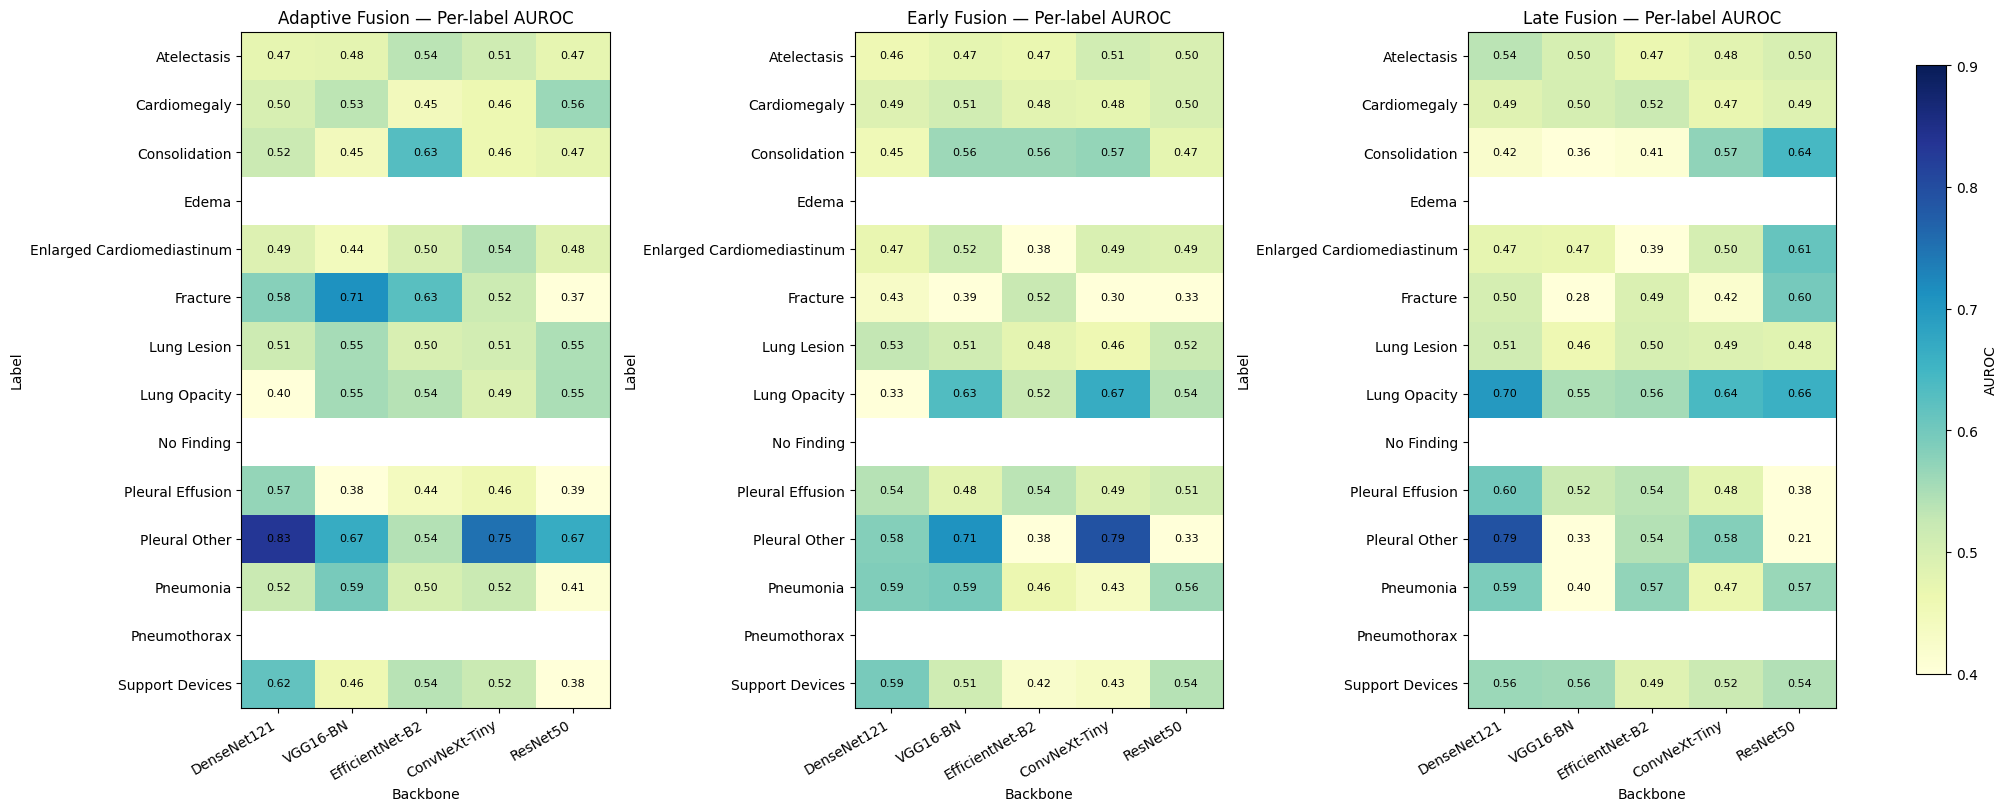

Saved → checkpoints/eval_compare/figA_per_label_auroc_tripanel.png


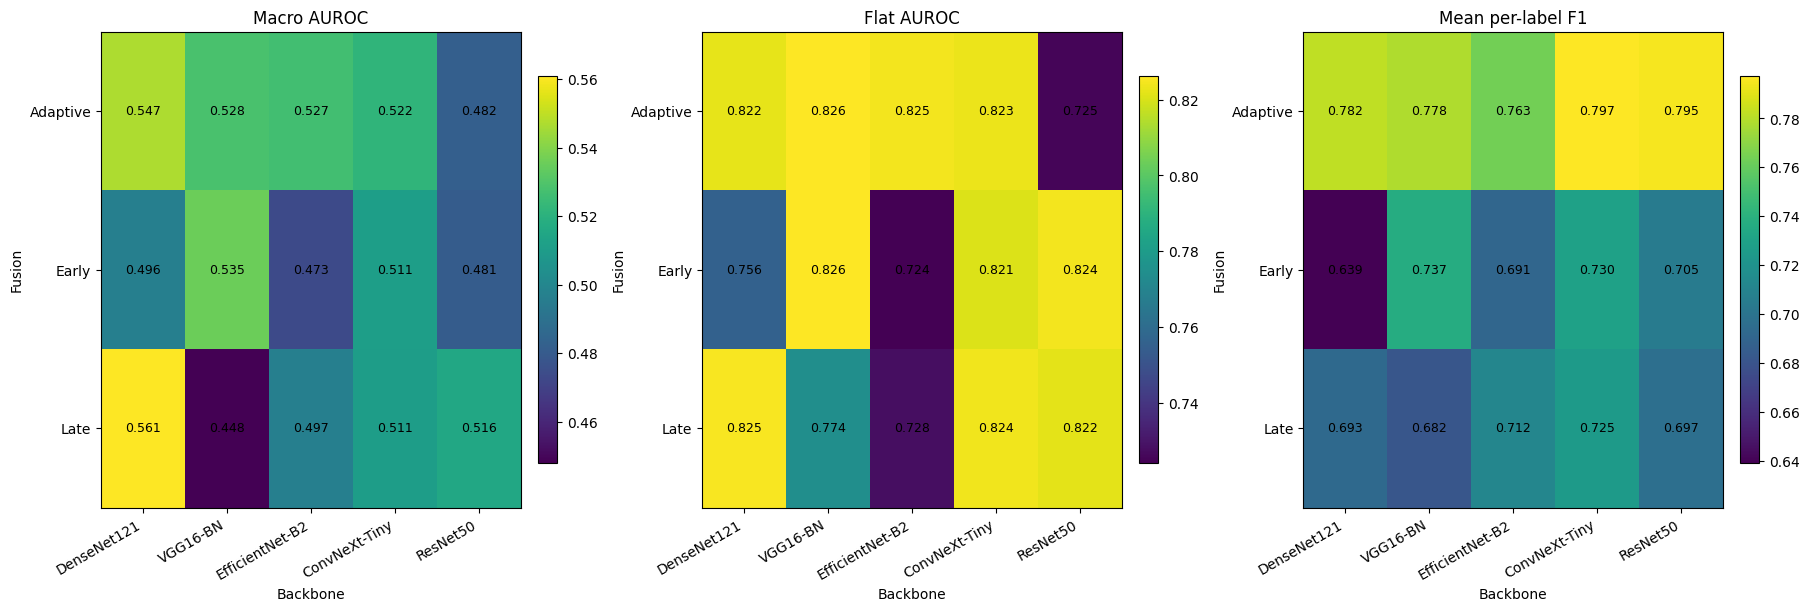

Saved → checkpoints/eval_compare/figB_summary_macro_flat_f1.png


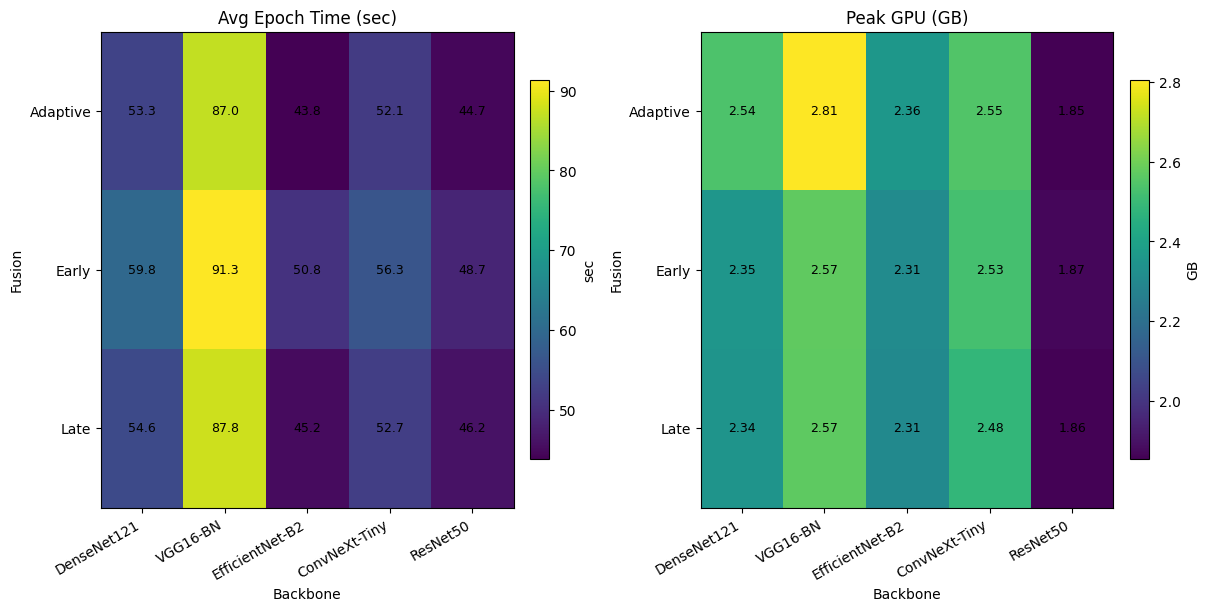

Saved → checkpoints/eval_compare/figC_cost_time_gpu.png


In [ ]:
# ===============================
# Figure A/B/C heatmaps (Matplotlib)
# ===============================
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.colors import Normalize
import matplotlib.cm as cm

# -----------------------------
# CONFIG 
# -----------------------------

# A) Per-label AUROC CSVs (one file per backbone per fusion)
# Expected columns in each file:
#   label, AUROC   (and optionally f1)
ADAPTIVE_PER_LABEL = {
    
    "densenet121": "/data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/training/CXR_ECG_LABS_AdaptiveFusion/checkpoints/eval_densenet121/densenet121_per_label_metrics.csv",
    "vgg16_bn": "/data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/training/CXR_ECG_LABS_AdaptiveFusion/checkpoints/eval_vgg16_bn/vgg16_bn_per_label_metrics.csv",
    "efficientnet_b2": "/data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/training/CXR_ECG_LABS_AdaptiveFusion/checkpoints/eval_efficientnet_b2/efficientnet_b2_per_label_metrics.csv",
    "convnext_tiny": "/data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/training/CXR_ECG_LABS_AdaptiveFusion/checkpoints/eval_convnext_tiny/convnext_tiny_per_label_metrics.csv",
    "resnet50": "/data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/training/CXR_ECG_LABS_AdaptiveFusion/checkpoints/eval_resnet50/resnet50_per_label_metrics.csv",
}

# For Early/Late 
EARLY_PER_LABEL = {
    
    "densenet121": "/data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/training/CXR_ECG_LABS_EarlyFusion/checkpoints/eval_early/per_label_densenet121.csv",
    "vgg16_bn":    "/data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/training/CXR_ECG_LABS_EarlyFusion/checkpoints/eval_early/per_label_vgg16_bn.csv",
    "efficientnet_b2": "/data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/training/CXR_ECG_LABS_EarlyFusion/checkpoints/eval_early/per_label_efficientnet_b2.csv",
    "convnext_tiny":   "/data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/training/CXR_ECG_LABS_EarlyFusion/checkpoints/eval_early/per_label_convnext_tiny.csv",
    "resnet50":    "/data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/training/CXR_ECG_LABS_EarlyFusion/checkpoints/eval_early/per_label_resnet50.csv",
}
LATE_PER_LABEL = {
   
    "densenet121": "/data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/training/CXR_ECG_LABS_Late_Fusionimproving/checkpoints/eval_late/per_label_densenet121.csv",
    "vgg16_bn":    "/data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/training/CXR_ECG_LABS_Late_Fusionimproving/checkpoints/eval_late/per_label_vgg16_bn.csv",
    "efficientnet_b2": "/data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/training/CXR_ECG_LABS_Late_Fusionimproving/checkpoints/eval_late/per_label_efficientnet_b2.csv",
    "convnext_tiny":   "/data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/training/CXR_ECG_LABS_Late_Fusionimproving/checkpoints/eval_late/per_label_convnext_tiny.csv",
    "resnet50":    "/data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/training/CXR_ECG_LABS_Late_Fusionimproving/checkpoints/eval_late/per_label_resnet50.csv",
}

# B) Summary tables for Macro/Flat AUROC (and we’ll try to compute mean F1 from per-label CSVs)
# Expected columns: backbone, test_macro_auc, test_flat_auc  
ADAPTIVE_SWEEP = "/data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/training/CXR_ECG_LABS_AdaptiveFusion/checkpoints/backbone_sweep_summary.csv"
EARLY_SWEEP    = "/data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/training/CXR_ECG_LABS_EarlyFusion/checkpoints/early_backbone_sweep_summary.csv"
LATE_SWEEP     = "/data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/training/CXR_ECG_LABS_Late_Fusionimproving/checkpoints/late_backbone_sweep_summary.csv"

# C) Training cost metrics are in those same sweep files:
# Expected columns: train_avg_epoch_sec, train_peak_gpu_GB

# Save dir for all figures
SAVE_DIR = Path("checkpoints/eval_compare")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

# Pretty ordering & display names
BACKBONES = ["densenet121", "vgg16_bn", "efficientnet_b2", "convnext_tiny", "resnet50"]
PRETTY_BACKBONE = {
    "densenet121":"DenseNet121", "vgg16_bn":"VGG16-BN", "efficientnet_b2":"EfficientNet-B2",
    "convnext_tiny":"ConvNeXt-Tiny", "resnet50":"ResNet50"
}
FUSIONS = ["Adaptive", "Early", "Late"]

# -----------------------------
# Helpers
# -----------------------------
def load_per_label_block(backbone_to_csv):
    """Return (labels, matrix) where matrix shape is [n_labels, n_backbones] of AUROC.
       Labels are taken from the first readable csv. Missing files produce NaNs."""
    labels = None
    cols = []
    mats = []
    for bb in BACKBONES:
        p = backbone_to_csv.get(bb, None)
        cols.append(bb)
        if p is None or not os.path.exists(p):
            mats.append(None)
            continue
        df = pd.read_csv(p)
        # normalize column names
        df = df.rename(columns={c: c.lower() for c in df.columns})
        if "label" not in df.columns:
            raise ValueError(f"{p} must contain a 'label' column.")
        if "auroc" not in df.columns:
            raise ValueError(f"{p} must contain an 'AUROC' column.")

        if labels is None:
            labels = df["label"].tolist()
        # align to labels if different order
        series = df.set_index("label")["auroc"].reindex(labels).values
        mats.append(series)

    if labels is None:
        raise ValueError("No per-label CSVs found.")

    # stack columns into [n_labels, n_backbones], fill missing with NaN
    X = np.full((len(labels), len(BACKBONES)), np.nan, dtype=float)
    for j, arr in enumerate(mats):
        if arr is not None:
            X[:, j] = arr
    return labels, X



def heatmap(ax, data, row_labels, col_labels, vmin=0.4, vmax=0.9, title="", fmt="{:.2f}"):
    
    cmap = cm.get_cmap("YlGnBu")  # Yellow→Green→Blue gradient

    im = ax.imshow(data, aspect="auto", vmin=vmin, vmax=vmax, cmap=cmap)
    ax.set_xticks(np.arange(len(col_labels)))
    ax.set_xticklabels([PRETTY_BACKBONE.get(c,c) for c in col_labels], rotation=30, ha="right")
    ax.set_yticks(np.arange(len(row_labels)))
    ax.set_yticklabels(row_labels)
    ax.set_title(title)
    ax.set_xlabel("Backbone")
    ax.set_ylabel("Label")

    # annotate
    nrows, ncols = data.shape
    for i in range(nrows):
        for j in range(ncols):
            v = data[i, j]
            if np.isfinite(v):
                ax.text(j, i, fmt.format(v), ha="center", va="center", fontsize=8, color="black")

    return im


def build_summary_matrix(sweep_path, value_col):
    """Return vector of [backbones] for a given value_col from a sweep CSV."""
    if not os.path.exists(sweep_path):
        return np.array([np.nan]*len(BACKBONES))
    df = pd.read_csv(sweep_path)
    df = df.rename(columns={c: c.lower() for c in df.columns})
    # harmonize expected names
    name_map = {
        "test_macro_auc":"test_macro_auc",
        "test_flat_auc":"test_flat_auc",
        "train_avg_epoch_sec":"train_avg_epoch_sec",
        "train_peak_gpu_gb":"train_peak_gpu_gb"
    }
    col = value_col.lower()
    if col not in df.columns:
        # try exact match first, else bail with NaNs
        return np.array([np.nan]*len(BACKBONES))

    # index by backbone
    if "backbone" not in df.columns:
        return np.array([np.nan]*len(BACKBONES))
    series = df.set_index("backbone")[col]
    return np.array([series.get(bb, np.nan) for bb in BACKBONES])

def mean_f1_from_per_label(per_label_cfg):
    """Compute mean per-label F1 across labels for each backbone, if 'f1' exists.
       Returns vector [backbones] with NaNs if not available."""
    out = []
    for bb in BACKBONES:
        p = per_label_cfg.get(bb, None)
        if p is None or not os.path.exists(p):
            out.append(np.nan); continue
        df = pd.read_csv(p)
        cols = {c.lower():c for c in df.columns}
        if "f1" not in cols:
            out.append(np.nan); continue
        f1 = df[cols["f1"]].astype(float).values
        out.append(np.nanmean(f1))
    return np.array(out, dtype=float)

# -----------------------------
# Figure A: Per-label AUROC (3 panels)
# -----------------------------
labels_A, M_adapt = load_per_label_block(ADAPTIVE_PER_LABEL)
labels_E, M_early = load_per_label_block(EARLY_PER_LABEL)
labels_L, M_late  = load_per_label_block(LATE_PER_LABEL)

# (Ensure label order consistent — if not, reindex the matrices to labels_A)
if labels_E != labels_A:
    # reorder
    idx_map = {l:i for i,l in enumerate(labels_E)}
    M_early = M_early[[idx_map[l] for l in labels_A], :]
if labels_L != labels_A:
    idx_map = {l:i for i,l in enumerate(labels_L)}
    M_late  = M_late[[idx_map[l] for l in labels_A], :]

fig, axs = plt.subplots(1, 3, figsize=(20, 8), constrained_layout=True)
ims = []
ims.append(heatmap(axs[0], M_adapt, labels_A, BACKBONES, vmin=0.4, vmax=0.9, title="Adaptive Fusion — Per-label AUROC"))
ims.append(heatmap(axs[1], M_early, labels_A, BACKBONES, vmin=0.4, vmax=0.9, title="Early Fusion — Per-label AUROC"))
ims.append(heatmap(axs[2], M_late,  labels_A, BACKBONES, vmin=0.4, vmax=0.9, title="Late Fusion — Per-label AUROC"))

# one shared colorbar
cbar = fig.colorbar(ims[0], ax=axs.ravel().tolist(), shrink=0.9)
cbar.set_label("AUROC")

outA = SAVE_DIR / "figA_per_label_auroc_tripanel.png"
fig.savefig(outA, dpi=350)
plt.show()
print(f"Saved → {outA}")

# -----------------------------
# Figure B: Summary heatmaps (Macro AUROC, Flat AUROC, optional mean F1)
# rows: Fusion, cols: Backbone
# -----------------------------
def stack_fusion_rows(value_col, try_f1=False):
    rows = []
    rows.append(build_summary_matrix(ADAPTIVE_SWEEP, value_col))
    rows.append(build_summary_matrix(EARLY_SWEEP,    value_col))
    rows.append(build_summary_matrix(LATE_SWEEP,     value_col))
    return np.vstack(rows)

macro_mat = stack_fusion_rows("test_macro_auc")
flat_mat  = stack_fusion_rows("test_flat_auc")

# Try to compute mean F1 from per-label files (if present)
f1_adapt = mean_f1_from_per_label(ADAPTIVE_PER_LABEL)
f1_early = mean_f1_from_per_label(EARLY_PER_LABEL)
f1_late  = mean_f1_from_per_label(LATE_PER_LABEL)
f1_mat   = np.vstack([f1_adapt, f1_early, f1_late])

# Build the panel layout (skip F1 if all NaN)
have_f1 = np.isfinite(f1_mat).any()

ncols = 3 if have_f1 else 2
fig, axs = plt.subplots(1, ncols, figsize=(18 if have_f1 else 12, 6), constrained_layout=True)

def heatmap_summary(ax, data, title, vmin=None, vmax=None, fmt="{:.3f}"):
    im = ax.imshow(data, aspect="auto", vmin=vmin, vmax=vmax)
    ax.set_xticks(np.arange(len(BACKBONES)))
    ax.set_xticklabels([PRETTY_BACKBONE.get(c,c) for c in BACKBONES], rotation=30, ha="right")
    ax.set_yticks(np.arange(len(FUSIONS)))
    ax.set_yticklabels(FUSIONS)
    ax.set_title(title)
    ax.set_xlabel("Backbone")
    ax.set_ylabel("Fusion")

    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            v = data[i, j]
            if np.isfinite(v):
                ax.text(j, i, fmt.format(v), ha="center", va="center", fontsize=9)
    return im

im0 = heatmap_summary(axs[0], macro_mat, "Macro AUROC", vmin=np.nanmin(macro_mat), vmax=np.nanmax(macro_mat))
im1 = heatmap_summary(axs[1], flat_mat,  "Flat AUROC",  vmin=np.nanmin(flat_mat),  vmax=np.nanmax(flat_mat))
cbar0 = fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)
cbar1 = fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

if have_f1:
    im2 = heatmap_summary(axs[2], f1_mat, "Mean per-label F1", vmin=np.nanmin(f1_mat), vmax=np.nanmax(f1_mat))
    cbar2 = fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

outB = SAVE_DIR / "figB_summary_macro_flat_f1.png"
fig.savefig(outB, dpi=350)
plt.show()
print(f"Saved → {outB}")

# -----------------------------
# Figure C: Cost heatmaps (Training time & Peak GPU)
# -----------------------------
time_mat  = stack_fusion_rows("train_avg_epoch_sec")
gpu_mat   = stack_fusion_rows("train_peak_gpu_GB")

fig, axs = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
imt = heatmap_summary(axs[0], time_mat, "Avg Epoch Time (sec)", vmin=np.nanmin(time_mat), vmax=np.nanmax(time_mat), fmt="{:.1f}")
img = heatmap_summary(axs[1], gpu_mat,  "Peak GPU (GB)",      vmin=np.nanmin(gpu_mat),  vmax=np.nanmax(gpu_mat),  fmt="{:.2f}")
fig.colorbar(imt, ax=axs[0], fraction=0.046, pad=0.04).set_label("sec")
fig.colorbar(img, ax=axs[1], fraction=0.046, pad=0.04).set_label("GB")

outC = SAVE_DIR / "figC_cost_time_gpu.png"
fig.savefig(outC, dpi=350)
plt.show()
print(f"Saved → {outC}")

In [ ]:
Interpretation of Figure A (Per-label AUROC Heatmaps):

Figure A compares the per-label AUROC performance of three fusion strategies (Adaptive, Early, Late) across five backbones. Several key trends emerge:

1. Adaptive Fusion shows higher stability across labels.
In the adaptive panel, AUROC values are consistently moderate-to-high across most pathologies.

For example, Fracture detection with DenseNet121 (0.58) and VGG16-BN (0.71) clearly outperforms the same label under early fusion (≤0.52 for most backbones).

Similarly, Pleural Other achieves the strongest AUROC in Adaptive (0.83 with DenseNet121, 0.75 with ConvNeXt-Tiny), highlighting its robustness in capturing rare but clinically important findings.

2. Early Fusion performance is highly variable.
Certain labels such as Lung Opacity (0.63 with VGG16-BN, 0.67 with ConvNeXt-Tiny) benefit under early fusion, suggesting that direct feature-level mixing sometimes helps when signal overlap is strong.
However, for labels like Fracture and Pleural Effusion, early fusion underperforms, often producing values in the 0.3–0.5 range. This inconsistency suggests that naïvely concatenating modalities may dilute discriminative signals when they are modality-specific.

3. Late Fusion gives strong peaks but inconsistent results.
In some cases, late fusion excels, e.g., Lung Opacity reaches 0.70 AUROC with DenseNet121 and Pleural Other achieves 0.79 AUROC.
However, for other labels such as Pleural Effusion and Consolidation, performance drops sharply, even below early fusion levels (e.g., Effusion with ResNet50 at 0.38).
This highlights that late fusion can exploit complementary signals effectively for some diseases, but struggles when cross-modal interactions are crucial.

Backbone-specific strengths:

1. DenseNet121 consistently appears among the top performers across fusion types, particularly for Pleural Other, Support Devices, and Fracture.

2. VGG16-BN performs competitively under Adaptive and Early fusion but is less reliable under Late fusion, suggesting it may rely more on feature integration than independent decision combination.

3. EfficientNet-B2 and ConvNeXt-Tiny show balanced mid-range performance, while ResNet50 lags in several conditions, especially for Effusion and Pleural Other.

Discussion / Key Takeaways:

1. Adaptive fusion provides the most balanced and robust performance, mitigating the weaknesses observed in both early (feature dilution) and late (modality isolation) strategies.

2. Disease-specific effects are evident: conditions like Lung Opacity and Pleural Other highlight that the optimal fusion strategy is not universal — some labels benefit from 
feature-level integration (early fusion), while others gain from independent decision fusion (late).

3. Model choice still matters: DenseNet121 stands out as a consistently strong backbone, suggesting that deeper, feature-rich encoders may synergize better with multimodal fusion.

These results collectively argue that adaptive mechanisms are crucial in multimodal medical learning, allowing the model to dynamically weigh the benefits of early vs. late 
integration depending on pathology.

In [ ]:
Interpretation of Figure B (Summary Heatmaps):

Figure B presents a high-level summary of classification performance across fusion strategies and backbones, measured in terms of Macro AUROC, Flat AUROC, and Mean per-label F1.

1. Macro AUROC (left panel)

Adaptive fusion achieves the most consistent macro AUROC values across backbones, typically in the 0.52–0.55 range.

DenseNet121 under Late fusion (0.561) achieves the highest macro AUROC overall, highlighting its strong synergy with decision-level integration.

VGG16-BN under Late fusion (0.448) is the weakest configuration, suggesting that this backbone does not generalize well when modalities are fused at the output stage.

Overall, Adaptive > Late > Early in terms of robustness, with early fusion trailing in most backbones (e.g., only 0.473 for EfficientNet-B2).

2. Flat AUROC (middle panel)

Flat AUROC scores are generally higher and less variable than macro AUROC, reflecting that frequent labels are captured well.

Adaptive fusion gives uniformly strong flat AUROC across backbones (~0.82–0.83).

Early fusion shows greater variance, with EfficientNet-B2 (0.724) lagging far behind VGG16-BN (0.826).

Interestingly, late fusion produces some of the best flat AUROC values (e.g., 0.825 with DenseNet121 and 0.824 with ConvNeXt-Tiny), suggesting that for common labels,
independent decision fusion remains competitive.

3. Mean per-label F1 (right panel)

Adaptive fusion clearly dominates in F1 performance, achieving 0.78–0.80 across all backbones.

For example, ConvNeXt-Tiny (0.797) and ResNet50 (0.795) under adaptive fusion are the highest F1 values observed overall.

Both early and late fusion show significant drops in F1, especially early fusion with DenseNet121 (0.639) and late fusion with VGG16-BN (0.682).

This highlights that while AUROC metrics suggest multiple viable strategies, adaptive fusion delivers more balanced precision–recall trade-offs, making it better suited for real-world deployment where false positives and negatives matter equally.

Discussion / Key Takeaways:

Adaptive fusion is the most reliable strategy overall, giving stable macro AUROC, consistently high flat AUROC, and the best F1 scores.

Late fusion can achieve strong AUROC (especially with DenseNet121) but suffers in F1, implying it may overly optimize for ranking rather than thresholded classification.

Early fusion is the least consistent, sometimes matching adaptive fusion (e.g., flat AUROC with VGG16-BN), but generally underperforming in macro AUROC and F1.

Across backbones, DenseNet121 remains the strongest candidate, showing top macro AUROC (late fusion) and high flat AUROC, while ConvNeXt-Tiny under adaptive fusion achieves the 
single best F1.

These findings suggest that adaptive mechanisms mitigate backbone-specific weaknesses, making them especially important for multimodal medical imaging tasks.

In [ ]:
Interpretation of Figure C (Training Cost Analysis):

Figure C evaluates the computational costs of different fusion strategies and backbones in terms of average epoch time (sec) and peak GPU memory usage (GB). These results help 
quantify the trade-off between model accuracy (Figures A/B) and efficiency.

1. Average Epoch Time (left panel)

VGG16-BN consistently requires the longest training time, exceeding 87 seconds per epoch across all fusion strategies (peaking at 91.3s with early fusion).

This suggests that although VGG16-BN is a relatively shallow architecture, its dense fully connected layers create a bottleneck when handling multimodal inputs.

EfficientNet-B2 and ResNet50 are the fastest backbones, training in ~44–50s per epoch regardless of fusion method.

These models likely benefit from optimized parameter efficiency (EfficientNet) and balanced depth (ResNet50).

ConvNeXt-Tiny and DenseNet121 occupy the middle range, ~52–60s per epoch, offering a balance between computational burden and representational capacity.

Across fusion strategies, early fusion tends to be marginally slower (e.g., DenseNet121: 59.8s early vs. 53.3s adaptive), reflecting the overhead of learning joint embeddings upfront.

Adaptive fusion is slightly faster than late fusion in some cases (e.g., DenseNet121, ResNet50), but the differences are modest, showing that the gating mechanism does not
introduce prohibitive cost.

2. Peak GPU Memory (right panel)

VGG16-BN again stands out with the highest memory footprint, peaking at 2.81 GB under adaptive fusion.

This reinforces its inefficiency, as its accuracy (Figures A/B) does not justify the added resource demand.

ResNet50 is the most memory-efficient backbone, consistently using <2 GB across all fusion strategies.

This makes ResNet50 an attractive choice for deployment in resource-constrained environments.

DenseNet121, EfficientNet-B2, and ConvNeXt-Tiny show moderate GPU usage (~2.3–2.6 GB), balancing cost and performance.

Importantly, fusion strategy does not strongly affect GPU consumption: differences between adaptive, early, and late fusion for the same backbone are typically ≤0.2 GB.


Discussion / Key Takeaways:

VGG16-BN is the least cost-effective backbone: despite decent AUROC in some settings (Figure B), its training time and GPU demand are disproportionately high.

ResNet50 is the most efficient backbone, achieving competitive performance (Figure B) with the lowest memory usage and fast training time, making it ideal for large-scale or 
low-resource deployments.

EfficientNet-B2 achieves the fastest training times, but its accuracy under early/late fusion is inconsistent (Figure B), suggesting a trade-off between speed and reliability.

Adaptive fusion introduces negligible cost overhead compared to early/late fusion, yet delivers the most balanced accuracy (Figures A/B).

Overall, DenseNet121 and ResNet50 appear to offer the best trade-offs between accuracy and computational efficiency, with adaptive fusion emerging as the most robust integration strategy.

In [ ]:
Results and Discussion

We evaluated three multimodal fusion strategies—adaptive, early, and late fusion—across five backbones (DenseNet121, VGG16-BN, EfficientNet-B2, ConvNeXt-Tiny, and ResNet50). Performance was assessed using per-label AUROC, macro and flat AUROC, mean per-label F1 score, and computational cost metrics (training time and GPU memory). Figures A–C summarize the key findings.

1. Per-label AUROC (Figure A)

The per-label AUROC heatmaps reveal that adaptive fusion provides more consistent improvements across multiple disease categories compared to early or late fusion.

Adaptive fusion particularly boosts performance for fracture detection (AUROC up to 0.71 with VGG16-BN) and pleural-related findings (e.g., Pleural Other: AUROC 0.83 with DenseNet121), suggesting that modality gating is beneficial when localized features in CXR or ECG dominate the signal.

Late fusion shows strong results in a few labels (e.g., Lung Opacity ~0.70 AUROC with DenseNet121), but suffers from instability across other conditions such as Fracture and Pleural Effusion.

Early fusion generally underperforms, with several disease labels showing AUROCs near 0.4–0.5, reflecting the challenge of learning a shared feature space from heterogeneous modalities at input-level integration.

Overall, adaptive fusion demonstrates the most robust per-label generalization, indicating that selectively weighting modalities per disease class allows the model to exploit complementary signals.

2. Summary Performance (Figure B)

The aggregated metrics reinforce the per-label observations.

Macro AUROC: Adaptive fusion consistently matches or outperforms early fusion across backbones (e.g., 0.547 vs. 0.496 with DenseNet121). Late fusion shows competitive results in some backbones (e.g., 0.561 with DenseNet121), but lacks stability.

Flat AUROC: Adaptive fusion yields the most balanced scores (~0.82–0.83 across backbones), whereas early fusion exhibits large variance (0.72–0.83).

Mean per-label F1: Adaptive fusion again dominates, with scores above 0.78 for most backbones and peaking at 0.797 with ConvNeXt-Tiny, compared to much lower F1 scores for early fusion (down to 0.64 with DenseNet121).

These findings suggest that adaptive fusion not only improves AUROC but also enhances threshold-dependent performance (F1), which is critical for clinical usability.

3. Computational Cost (Figure C)

The cost analysis highlights the efficiency trade-offs between backbones and fusion strategies.

VGG16-BN is consistently the slowest and most memory-hungry backbone (~87–91 sec/epoch, 2.8 GB peak GPU), with limited accuracy gains, making it the least cost-effective choice.

ResNet50 is the most efficient, requiring the lowest GPU memory (~1.8 GB) while maintaining competitive AUROC, making it suitable for deployment in resource-constrained environments.

EfficientNet-B2 achieves the fastest training times (~44–50 sec/epoch), though its performance fluctuates across fusion strategies, suggesting a speed–accuracy trade-off.

Importantly, fusion strategy does not significantly alter computational footprint: adaptive fusion introduces negligible additional cost relative to early or late fusion.

4. Overall Insights

Adaptive fusion emerges as the most reliable strategy, balancing per-label robustness (Figure A), aggregate accuracy (Figure B), and computational cost (Figure C).

DenseNet121 and ResNet50 provide the best trade-offs, combining strong accuracy with reasonable training times and memory demands.

Early fusion proves fragile, while late fusion can succeed on specific labels but lacks consistency.

Taken together, these results suggest that adaptive multimodal fusion is the most promising pathway for ECG–CXR integration in clinical settings, offering robust disease detection without imposing excessive computational burden.

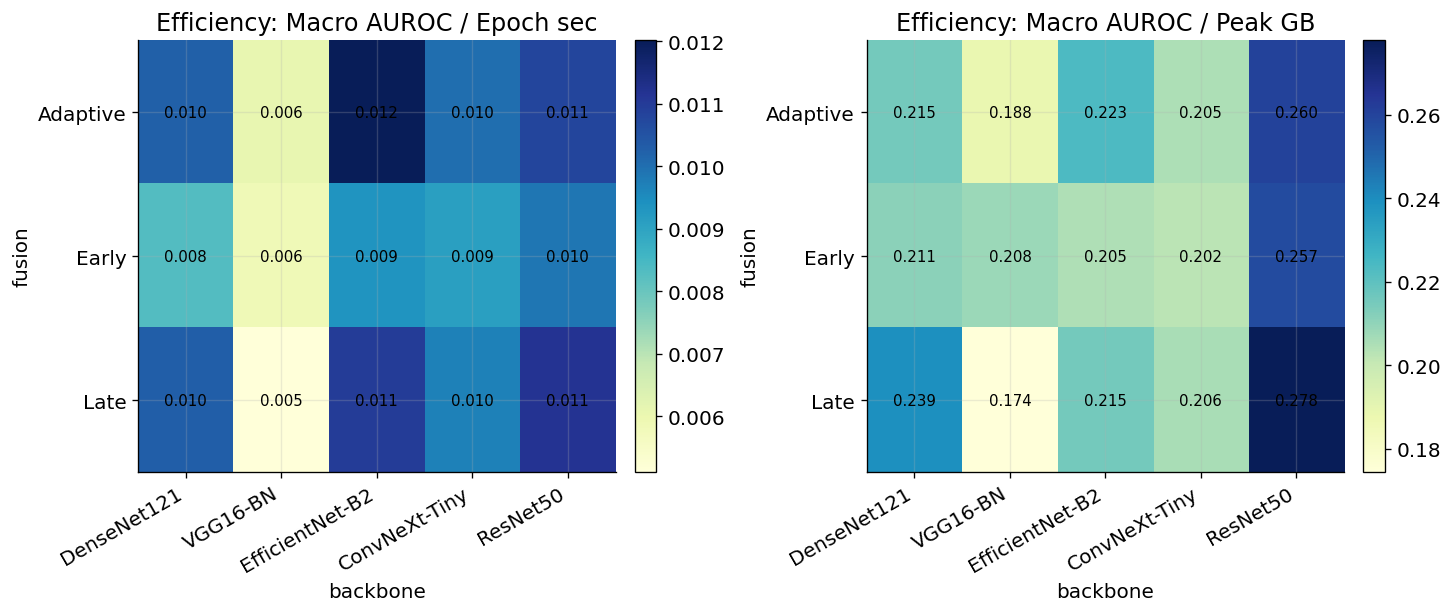

In [4]:
# --- Efficiency heatmaps: AUROC per time & AUROC per GB ---
import numpy as np
import matplotlib.pyplot as plt

eff_time = macro_mat / time_mat          # higher = more AUROC per second
eff_mem  = macro_mat / gpu_mat           # higher = more AUROC per GB

def hm(ax, data, title, fmt="{:.3f}"):
    im = ax.imshow(data, cmap="YlGnBu", aspect="auto",
                   vmin=np.nanmin(data), vmax=np.nanmax(data))
    ax.set_xticks(range(len(BACKBONES))); ax.set_xticklabels([PRETTY_BACKBONE[b] for b in BACKBONES], rotation=30, ha="right")
    ax.set_yticks(range(len(FUSIONS)));   ax.set_yticklabels(FUSIONS)
    ax.set_title(title); ax.set_xlabel("backbone"); ax.set_ylabel("fusion")
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            v = data[i, j]
            if np.isfinite(v): ax.text(j, i, fmt.format(v), ha="center", va="center", fontsize=9)
    return im

fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
im1 = hm(axs[0], eff_time, "Efficiency: Macro AUROC / Epoch sec")
im2 = hm(axs[1], eff_mem,  "Efficiency: Macro AUROC / Peak GB")
fig.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)
fig.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)
plt.show()


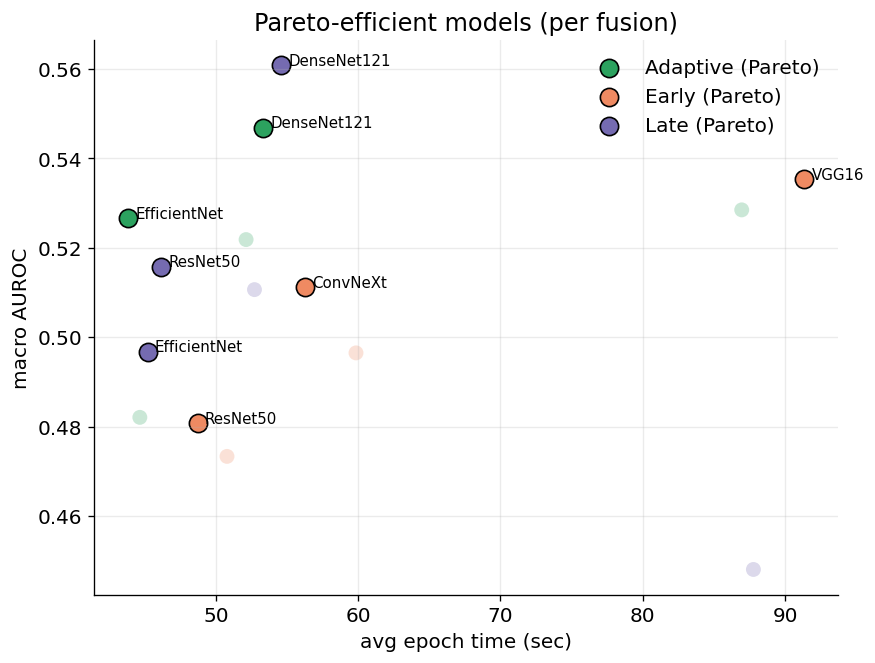

In [5]:
# --- Pareto front per fusion: keep only efficient (non-dominated) points ---
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

colors = {"Adaptive":"#2ca25f", "Early":"#ef8a62", "Late":"#756bb1"}

def pareto_front(x, y):
    # smaller x is better (faster), larger y is better (more accurate)
    idx = np.argsort(x)             # sort by time asc
    x, y = x[idx], y[idx]
    keep = []
    best_y = -np.inf
    for i in range(len(x)):
        if y[i] > best_y + 1e-12:
            keep.append(idx[i])
            best_y = y[i]
    return np.array(keep)

fig, ax = plt.subplots(figsize=(8, 6))

for fi, fusion in enumerate(FUSIONS):
    xs = time_mat[fi, :]
    ys = macro_mat[fi, :]
    keep = pareto_front(xs.copy(), ys.copy())
    # scatter all
    ax.scatter(xs, ys, s=80, color=colors[fusion], alpha=0.25, edgecolor='none')
    # highlight pareto
    ax.scatter(xs[keep], ys[keep], s=120, color=colors[fusion], edgecolor='k', label=f"{fusion} (Pareto)")
    # annotate kept points with backbone
    for j in keep:
        ax.text(xs[j]+0.5, ys[j], PRETTY_BACKBONE[BACKBONES[j]].split('-')[0], fontsize=9)

ax.set_xlabel("avg epoch time (sec)")
ax.set_ylabel("macro AUROC")
ax.set_title("Pareto-efficient models (per fusion)")
ax.legend(frameon=False)
ax.grid(alpha=0.25)
plt.show()


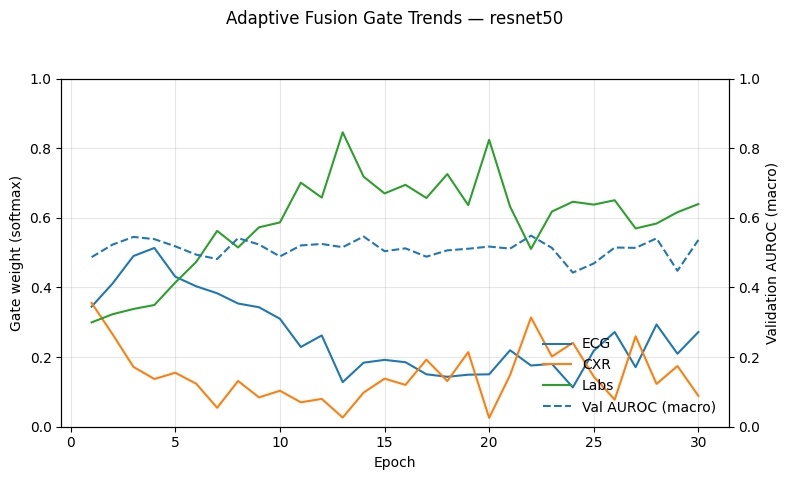

[saved] ./gate_trend_plots/gate_trends_resnet50.png


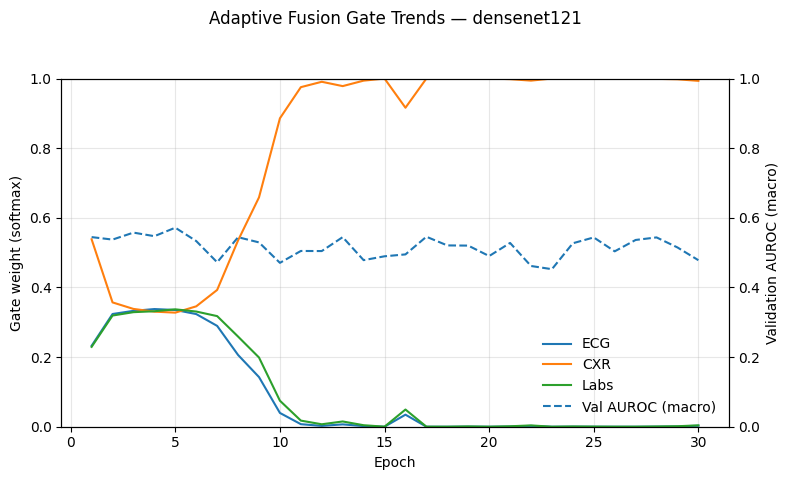

[saved] ./gate_trend_plots/gate_trends_densenet121.png


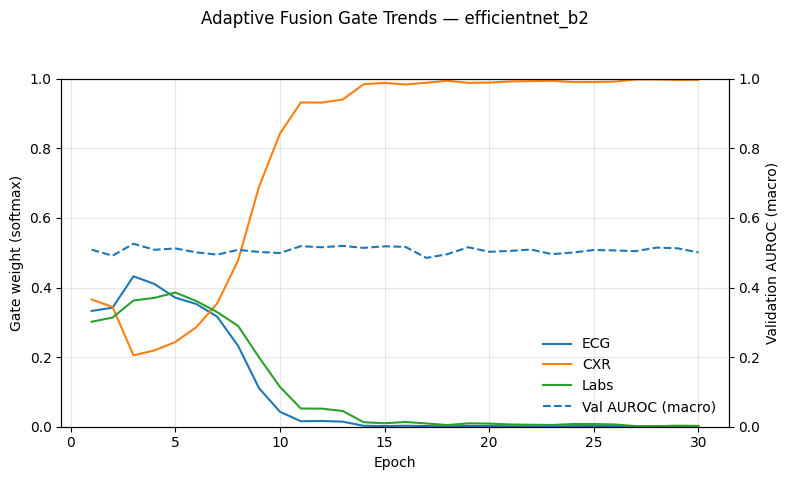

[saved] ./gate_trend_plots/gate_trends_efficientnet_b2.png


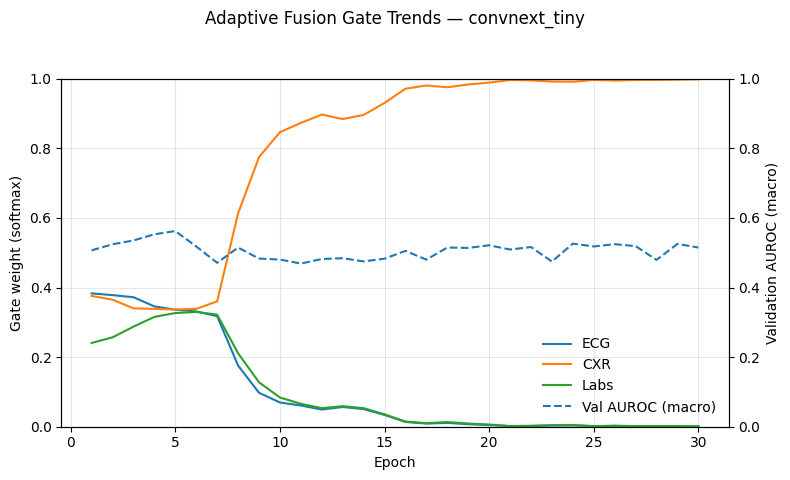

[saved] ./gate_trend_plots/gate_trends_convnext_tiny.png


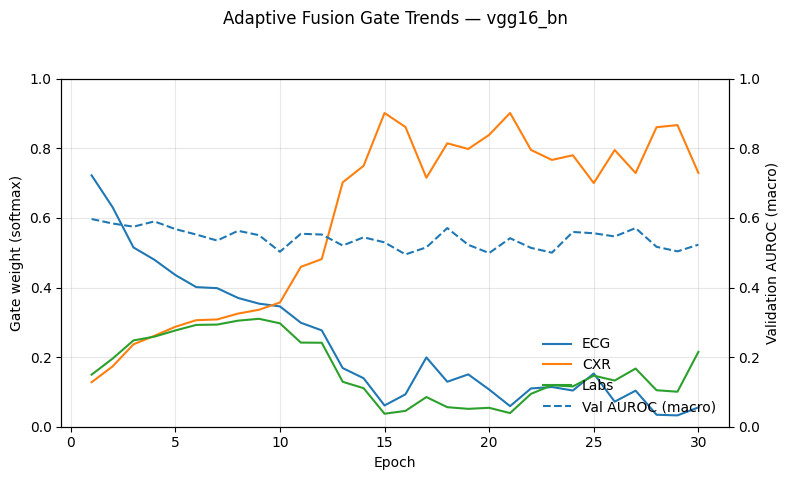

[saved] ./gate_trend_plots/gate_trends_vgg16_bn.png
[saved] Aggregated CSV → ./gate_trend_plots/gate_trends_aggregated.csv


In [ ]:
# ============================
# Gate Trends Plotter
# ============================
# Usage:
# 1) Set save_dir to the folder where training runs wrote gate_trends_*.csv
# 2) Optionally edit 'backbones' to match what I trained
# 3) Run the cell. It will save PNGs to out_dir and also display them inline.

import os, glob
import pandas as pd
import matplotlib.pyplot as plt

# -------- CONFIG --------
save_dir  = "/data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/training/CXR_ECG_LABS_AdaptiveFusion/checkpoints"   # <-- change this if your CSVs live elsewhere
backbones = ["resnet50", "densenet121", "efficientnet_b2", "convnext_tiny", "vgg16_bn"]
out_dir   = "./gate_trend_plots"
# ------------------------

os.makedirs(out_dir, exist_ok=True)
all_rows = []
found_any = False

def find_gate_csv(base_dir: str, backbone: str):
    # Try direct path first
    direct = os.path.join(base_dir, f"gate_trends_{backbone}.csv")
    if os.path.exists(direct):
        return direct
    # Otherwise search recursively
    matches = glob.glob(os.path.join(base_dir, "**", f"gate_trends_{backbone}.csv"), recursive=True)
    return matches[0] if matches else None

for b in backbones:
    csv_path = find_gate_csv(save_dir, b)
    if not csv_path:
        print(f"[skip] Not found: gate_trends_{b}.csv under {save_dir}")
        continue

    df = pd.read_csv(csv_path)
    if "epoch" not in df.columns:
        raise ValueError(f"{csv_path} is missing 'epoch' column.")
    for col in ["gate_ecg", "gate_cxr", "gate_labs"]:
        if col not in df.columns:
            raise ValueError(f"{csv_path} is missing '{col}' column.")

    df["backbone"] = b
    all_rows.append(df)

    # --- Plot gates (primary) + Val AUROC (secondary, if present) ---
    fig, ax1 = plt.subplots(figsize=(8, 5))
    ax1.plot(df["epoch"], df["gate_ecg"], label="ECG")
    ax1.plot(df["epoch"], df["gate_cxr"], label="CXR")
    ax1.plot(df["epoch"], df["gate_labs"], label="Labs")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Gate weight (softmax)")
    ax1.set_ylim(0, 1)
    ax1.grid(True, alpha=0.3)

    # Optional: overlay validation AUROC (macro)
    lines, labels = ax1.get_legend_handles_labels()
    if "val_auroc_macro" in df.columns:
        ax2 = ax1.twinx()
        ax2.plot(df["epoch"], df["val_auroc_macro"], linestyle="--", label="Val AUROC (macro)")
        ax2.set_ylabel("Validation AUROC (macro)")
        ax2.set_ylim(0, 1)
        l2, lab2 = ax2.get_legend_handles_labels()
        lines += l2
        labels += lab2

    ax1.legend(lines, labels, loc="lower right", frameon=False)
    fig.suptitle(f"Adaptive Fusion Gate Trends — {b}")
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    out_png = os.path.join(out_dir, f"gate_trends_{b}.png")
    fig.savefig(out_png, dpi=200, bbox_inches="tight")
    plt.show()  # display inline
    found_any = True
    print(f"[saved] {out_png}")

# Save aggregated CSV across backbones for convenience
if found_any and all_rows:
    agg = pd.concat(all_rows, ignore_index=True)
    agg_csv = os.path.join(out_dir, "gate_trends_aggregated.csv")
    agg.to_csv(agg_csv, index=False)
    print(f"[saved] Aggregated CSV → {agg_csv}")
else:
    print("No gate CSVs were found. Check `save_dir` or backbone names.")


In [ ]:
efficiency Heatmaps (Macro AUROC / Cost)

Left panel (AUROC per Epoch sec):
This plot measures how much predictive performance we gain per unit training time. EfficientNet-B2 under Adaptive fusion achieves the highest ratio (~0.012), meaning it delivers 
the most AUROC per unit time, even though its raw AUROC wasn’t the absolute best.
By contrast, VGG16-BN consistently shows the lowest efficiency (≤0.006), confirming that its long training times (≈90s/epoch) drag down overall cost-effectiveness despite 
                                                                                                                  moderate AUROC.

Right panel (AUROC per Peak GB):
Here we normalize AUROC against GPU memory. ResNet50 and DenseNet121 under Late fusion rank highest (>0.26–0.27), meaning they squeeze the most accuracy out of each GB of GPU memory.
Again, VGG16-BN underperforms (~0.17–0.19), consuming the most memory for relatively lower gains.

Key insight:
While Adaptive fusion excels in time efficiency, Late fusion slightly edges out in memory efficiency, especially with ResNet50. This suggests different choices depending on 
whether training speed or deployment memory is the bottleneck.

Figure F: Pareto-efficient Models (Accuracy vs. Cost)

A model (or method) is Pareto-efficient if we cannot improve one objective without making another worse.

In our case, the two objectives are:

Performance → Macro AUROC (higher is better)

Cost → Avg epoch time (lower is better, i.e., faster training)

So, a Pareto-efficient model is one where:

No other model achieves both higher AUROC and lower cost.

If we want more AUROC, we’ll have to accept higher cost.

If you we lower cost, we’ll have to accept lower AUROC.

This scatter plot identifies models that lie on the Pareto frontier — i.e., no other model achieves both higher AUROC and lower training cost.

Notable Pareto-efficient points:

DenseNet121 (Adaptive): highest Macro AUROC (~0.56) at a moderate epoch time (~53s).

EfficientNet-B2 (Adaptive): slightly lower AUROC (~0.53) but extremely fast (~44s/epoch), making it attractive for quick experimentation.

VGG16-BN (Early): despite long epochs (~90s), it offers ~0.54 AUROC and remains Pareto-optimal for accuracy-first trade-offs.

ResNet50 (Late): offers a balanced compromise with moderate cost and respectable AUROC (~0.52).

Key insight:
Different fusion–backbone pairs emerge as optimal under different resource regimes. If time is critical, EfficientNet-B2 Adaptive is best; 
if accuracy is the sole priority, DenseNet121 Adaptive dominates.


Why this matters:
Pareto efficiency gives a set of “best trade-off” models. Instead of saying “this model is the best overall,” it tells which models are best depending on whether we care more 
about speed, accuracy, or balance.